In [1]:
%pwd

'C:\\Users\\Mike\\github\\Experimental-Study-of-Entropy-in-SNA'

In [149]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols


# Setup

datafile = 'data.npy'
image_path = './practice_images/'

data = np.load(datafile)
num_trials = data.shape[0]


In [150]:
# plot styling
plt.style.use('seaborn-colorblind')

import matplotlib
# Plot size to 14" x 7"
matplotlib.rc('figure', figsize = (8, 4.5) )
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)


# Set an aspect ratio
# width, height = plt.figaspect(1.68)
# fig = plt.figure(figsize=(width,height), dpi=400)


Text(0, 0.5, 'entropy')

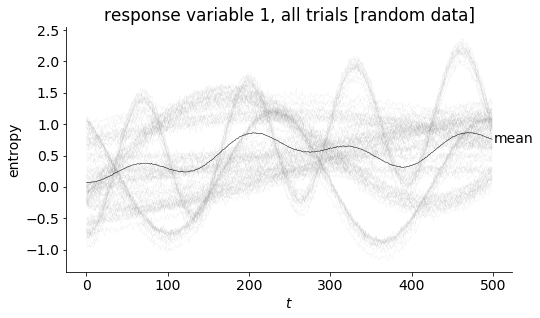

In [151]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

rv = 1  # just to select single response variable
for i in range(90):  ##
    ax1.plot(data[i, :, rv], marker='', color='grey', linewidth=0.10, alpha=0.5)

# mean of data
mean_data = np.average(data, axis=0)[:, rv]
ax1.plot(mean_data, marker='', color='black', linewidth=0.50, alpha=1)
ax1.annotate('mean', (data.shape[1] + 1, mean_data[-1]), ha='left', va='center', annotation_clip=False, color='black')    
    
ax1.set_title('response variable 1, all trials [random data]')
ax1.set_xlabel('$t$')
ax1.set_ylabel('entropy')


In [152]:
fig1.savefig('practice_images/example_0.png', bbox_inches='tight')


# RQ 1 - DoE/ANOVA


In [153]:
design_df = pd.read_csv('design.csv', index_col=0, dtype=str)

num_trials = data.shape[0]
design_df = design_df.sample(num_trials)

In [154]:
# cast output data for single RV to df to help with grouping
df = pd.DataFrame(data[:, :, rv])  # |TRIALS| x t_max
df.index = design_df.index

ddff = design_df.join(df)
ddff.head()

,agent_activation_regime,influence_error_distribution,influence_model,network_structure_model,population_size,0,1,2,3,4,...,490,491,492,493,494,495,496,497,498,499
1193,uniform,"N(0, 0.2)",nonlinear,"scale_free(n, 1)",10000,-0.017333,0.046442,0.093520,0.007754,0.077596,...,0.121101,0.196951,0.253786,0.264049,0.239013,0.201156,0.261987,0.258101,0.312356,0.318044
612,uniform,none,standard_model,"small_world(n, 0.33, 10)",100,-0.586046,-0.579732,-0.574283,-0.562991,-0.554800,...,1.093584,1.077086,1.071091,1.105031,1.055197,1.076565,1.090663,1.103233,1.071300,1.108334
1476,random,"N(0, 0.05)",nonlinear,"small_world(n, 0.0, 10)",100,1.045223,1.050373,1.043293,1.033493,1.029057,...,1.081462,1.028136,1.079730,1.073004,1.025700,1.088156,1.075093,1.012843,1.109886,1.041569
1101,uniform,"N(0, 0.2)",similarity_bias,"scale_free(n, 1)",100,-0.714001,-0.751875,-0.668790,-0.712599,-0.764615,...,1.340036,1.307168,1.242234,1.242304,1.176461,1.124355,1.034815,1.069850,1.022549,0.951502
1684,random,"N(0, 0.2)",similarity_bias,"small_world(n, 0.0, 3)",1000,-0.716059,-0.739119,-0.812477,-0.716757,-0.799057,...,1.307095,1.254668,1.243363,1.177899,1.153264,1.099706,1.091651,1.004982,0.940250,0.912971


In [155]:
for col in design_df:
    print(design_df[col].unique())

['uniform' 'random' 'synchronous']
['N(0, 0.2)' 'none' 'N(0, 0.05)' 'N(0, 0.1)']
['nonlinear' 'standard_model' 'similarity_bias' 'random_adoption'
 'attractive_repulsive']
['scale_free(n, 1)' 'small_world(n, 0.33, 10)' 'small_world(n, 0.0, 10)'
 'small_world(n, 0.0, 3)' 'scale_free(n, 5)' 'small_world(n, 0.33, 3)'
 'small_world(n, 0.66, 10)' 'erdos_renyi_random(n)' 'scale_free(n, 3)'
 'small_world(n, 0.66, 3)']
['10000' '100' '1000']


In [156]:
# DoE mean plot - data collection

label_map = dict(
    agent_activation_regime='activation',
    influence_error_distribution='error',
    influence_model='influence model',
    network_structure_model='structure',
    population_size='$N$',
)

factors = []
num_levels = []
means = []  # mean value for each factor-level
for col in design_df:
    factors.append(col)
    
    levels = design_df[col].unique()
    num_levels.append(len(levels))
    
    means.extend(ddff.groupby(col).mean()[499])  # as written, do need ddff here
    
# this averaged random data is boring for demonstration purposes (all basically 0.5), so here's some new ones
# oh wait I made my practice data better
# means = [.4, .5, .6, .44, .42, .7, .3, .1, .3, .43, .65, .13, .5, .5, .6, .44, .42, .7, .3, .1, .3, .43, .65, .13, .5]

In [157]:
# prepare plot data

cur_x = factor_start = factor_end = 0
xticks = []
xlabels = []
factor_name_xs = []

for i, factor in enumerate(factors):
    cur_x += 1  # add horizontal space before factor
    factor_start = cur_x
    
    levels = num_levels[i]
    for l in range(1, levels+1):
        xticks.append(cur_x)
        xlabels.append(l)
        cur_x += 1
        
    factor_end = cur_x
    factor_name_xs.append((label_map[factor], 0.5*(factor_end-1 + factor_start)))
    
    cur_x += 1  # add horizontal space after factor
    
# xticks, xlabels, 
factor_name_xs

[('activation', 2.0),
 ('error', 7.5),
 ('influence model', 14.0),
 ('structure', 23.5),
 ('$N$', 32.0)]

Text(0, 0.5, 'mean entropy')

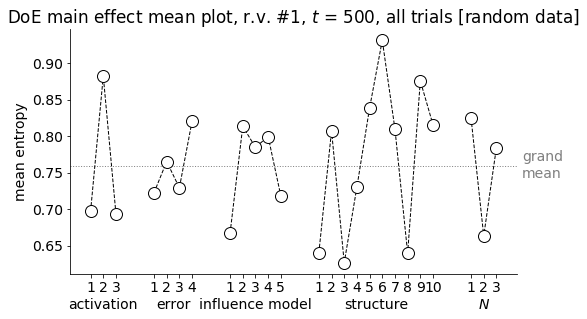

In [158]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

# assemble x tick labels
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)

grand_mean = df.mean().iloc[-1]
ax1.axhline(y=grand_mean, color='grey', linewidth=1, linestyle=':')
ax1.annotate('grand\nmean', (xticks[-1]+2, grand_mean), ha='left', va='center', annotation_clip=False, color='grey')

last_offset = 0
for i, factor in enumerate(factors):
    x = xticks[last_offset:last_offset+num_levels[i]]
    y = means[last_offset:last_offset+num_levels[i]]
    
    ax1.plot(x, y, color='black', 
             markerfacecolor='white', linewidth=1, linestyle='--', marker='o', markersize=12)
    
    last_offset += num_levels[i]

# label factor names
y = ax1.get_ybound()[0]
for label, x in factor_name_xs:
    ax1.annotate(label, (x, y), 
                 textcoords="offset points", # how to position the text
                 xytext=(0,-35), # distance from text to points (x,y)
                 ha='center', annotation_clip=False)
    


    
ax1.set_title('DoE main effect mean plot, r.v. #1, $t$ = 500, all trials [random data]')
ax1.set_ylabel('mean entropy')

In [159]:
fig1.savefig('practice_images/example_1.png', bbox_inches='tight')

Text(0, 0.5, 'response variable 1')

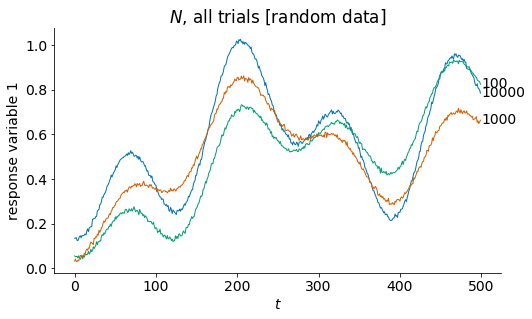

In [160]:
# time-series line plot, single RV, single design factor, grouped by level + level average line

factor_num = 4  # just doing single factor for now
factor = factors[factor_num]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

levels = design_df[factor].unique()  # levels for the selected factor
for level in levels:
    level_data = df.loc[design_df[factor] == level]
    level_mean = level_data.mean()

    
    ax1.plot(level_mean, marker='',  linewidth=1)
    ax1.annotate(level, (level_mean.index[-1]+1, level_mean.iloc[-1]), ha='left', va='center', annotation_clip=False, color='black')
    
    
# error bands, or plot all the data lightly?
# if error bands:
# x = df_mean.index
# plt.plot(x, df_mean, color="white", lw=2) 
# plt.fill_between(x, df_mean - df_se, df_mean + df_se, color="#3F5D7D")  
    
ax1.set_title('{}, all trials [random data]'.format(label_map[factor]))
ax1.set_xlabel('$t$')
ax1.set_ylabel('response variable {}'.format(rv))


In [161]:
fig1.savefig('practice_images/example_2.png', bbox_inches='tight')

In [162]:
# correlogram between mean of time series, per factor level

items = []
for factor in factors:
    levels = design_df[factor].unique()  # levels for the selected factor
    items.extend(['{}:{}'.format(factor, level) for level in levels])
    
corr_df = pd.DataFrame(index=items, columns=items, data=np.zeros((len(items), len(items))), dtype=float)
tmp_df = pd.DataFrame(index=items, columns=[0], dtype=object)


# first, extract mean time-series per groupedby factor-level
for factor in factors:
    levels = design_df[factor].unique()  # levels for the selected factor
    
    for level in levels:
        level_data = df.loc[design_df[factor] == level]
        level_mean = level_data.mean()
        
        tmp_df.at['{}:{}'.format(factor, level), 0] = level_mean.to_numpy()
        
# then find Pearson correlation coefficient between each pair
for i, v in enumerate(tmp_df.index):
    for j, w in enumerate(tmp_df.index):
        corr_df.at[v, w] = np.corrcoef(tmp_df.at[v, 0], tmp_df.at[w, 0])[0, 1]

Text(0.5, 1.0, 'correlation of mean time-series, r.v. 1 [random data!]')

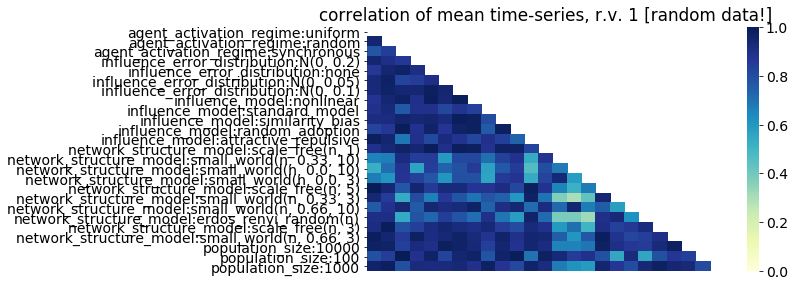

In [163]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

slice_start = 0
slice_end = 25
sub_data = corr_df.iloc[slice_start:slice_end, slice_start:slice_end]

mask = np.zeros_like(sub_data)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(sub_data, ax=ax1, mask=mask, cmap="YlGnBu", vmin=0, vmax=1, xticklabels=False, yticklabels=True)
    
ax1.set_title('correlation of mean time-series, r.v. 1 [random data!]'.format(label_map[factor]))

In [164]:
fig1.savefig('practice_images/example_3.png', bbox_inches='tight')

In [165]:
# ANOVA on the data and pleasing output
#
# https://pythonfordatascience.org/anova-python/ is good walkthrough for this + assumption checks/diagnostics

# ANOVA on the final ($t = 500$) data for r.v.1
t = 499
# anova_data = data[:, t, rv]
anova_df = design_df.copy()
anova_df['response'] = data[:, t, rv]


# must first ensure data meets preconditions for ANOVA (homogeneity/normality)!
"""
Normality
Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality
Homogeneity of variance
Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation
Independent observations
"""

results = ols('response ~ {}'.format(' + '.join(factors)), data=anova_df).fit()  # TODO make right formula for categoricals?
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.101
Date:                Wed, 29 May 2019   Prob (F-statistic):              0.369
Time:                        23:11:58   Log-Likelihood:                -25.417
No. Observations:                  90   AIC:                             92.83
Df Residuals:                      69   BIC:                             145.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.5502      0.191      2.885      0.005       0.170       0.931
agent_activation_regime[T.synchronous]                  0.2266      0.113      2.015      0.048       0.002       0.451
agent_activation_regime[T.uniform]                      0.0280      0.117      0.239      0.812      -0.206       0.262
influence_error_distribution[T.N(0, 0.1)]               0.0007      0.119      0.005      0.996      -0.238       0.239
influence_error_distribution[T.N(0, 0.2)]              -0.0448      0.137     -0.327      0.745      -0.319       0.229
influence_error_distribution[T.none]                    0.0991      0.134      0.741      0.461      -0.168       0.366
influence_model[T.nonlinear]                            0.2216      0.130      1.701      0.094      -0.038       0.481
influence_model[T.random_adoption]                      0.1847      0.154      1.197      0.235      -0.123       0.492
influence_model[T.similarity_bias]                      0.2592      0.136      1.909      0.060      -0.012       0.530
influence_model[T.standard_model]                       0.1729      0.135      1.277      0.206      -0.097       0.443
network_structure_model[T.scale_free(n, 1)]             0.0679      0.178      0.383      0.703      -0.286       0.422
network_structure_model[T.scale_free(n, 3)]            -0.1077      0.165     -0.653      0.516      -0.437       0.221
network_structure_model[T.scale_free(n, 5)]             0.0454      0.187      0.243      0.809      -0.327       0.418
network_structure_model[T.small_world(n, 0.0, 10)]      0.0571      0.211      0.271      0.788      -0.364       0.479
network_structure_model[T.small_world(n, 0.0, 3)]       0.2887      0.211      1.370      0.175      -0.132       0.709
network_structure_model[T.small_world(n, 0.33, 10)]     0.0941      0.199      0.473      0.637      -0.302       0.491
network_structure_model[T.small_world(n, 0.33, 3)]     -0.1445      0.187     -0.772      0.443      -0.518       0.229
network_structure_model[T.small_world(n, 0.66, 10)]     0.0863      0.178      0.486      0.629      -0.268       0.441
network_structure_model[T.small_world(n, 0.66, 3)]      0.2088      0.183      1.143      0.257      -0.156       0.573
population_size[T.1000]                                -0.2568      0.105     -2.435      0.017      -0.467      -0.046
population_size[T.10000]                               -0.0789      0.105     -0.752      0.455      -0.288       0.130
==============================================================================
Omnibus:                        1.518   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.468   Jarqu

In [166]:
# alternatively
for table in results.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     response     & \textbf{  R-squared:         } &    0.242  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.022  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    1.101  \\
\textbf{Date:}             & Wed, 29 May 2019 & \textbf{  Prob (F-statistic):} &   0.369   \\
\textbf{Time:}             &     23:12:02     & \textbf{  Log-Likelihood:    } &  -25.417  \\
\textbf{No. Observations:} &          90      & \textbf{  AIC:               } &    92.83  \\
\textbf{Df Residuals:}     &          69      & \textbf{  BIC:               } &    145.3  \\
\textbf{Df Model:}         &          20      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lccc

In [61]:
# post-hoc Tukey tests? it's on the pfds.org page too!

...TODO

SyntaxError: invalid syntax (<ipython-input-61-18d8a82b4998>, line 3)


# RQ 2 - Cluster analysis


In [228]:
from scipy import stats
import scipy.cluster.hierarchy as hac

from dtw import accelerated_dtw
import time  # just for timing DTW loop

# setup the data...
cluster_data = data[:, :, rv]

# manually compute distance matrices to have better control over what's going on + to get access to DTW
distances_pearson = np.corrcoef(cluster_data)  # created as symmetric mtx

# transform correlation [-1, 1] to dissimalarity measure [0, 2]
distances_pearson = distances_pearson + 1

In [385]:
distances_dtw = np.load('distances_dtw.npy')  ## since it's so time-costly to generate in the next cell, save-load it in case I need to do this again before real-data.

In [205]:
# ##
# # WARNING: for 90 trials, this takes 65minutes! need to parallellize it
# ##

# euclidean_norm = lambda x, y: np.abs(x - y)

# distances_dtw = np.zeros_like(distances_pearson)

# start_time = time.time()
# for i in range(num_trials):
#     for j in range(num_trials):
#         if j < i:  # matrix is symmetric so don't compute upper half
#             d, _, _, _ = accelerated_dtw(
#                 cluster_data[i, :], 
#                 cluster_data[j, :], 
#                 dist=euclidean_norm)
#             distances_dtw[i, j] = d

# print('time for DTW on {}^2 = {}'.format(num_trials, time.time() - start_time))

# distances_dtw = distances_dtw + distances_dtw.T  # to make symmetric for later

time for DTW on 90^2 = 3876.668627500534


In [384]:
np.save('distances_dtw.npy', distances_dtw)

Text(0.5, 0.98, 'distance matrix, r.v. 1, all trials [random data]')

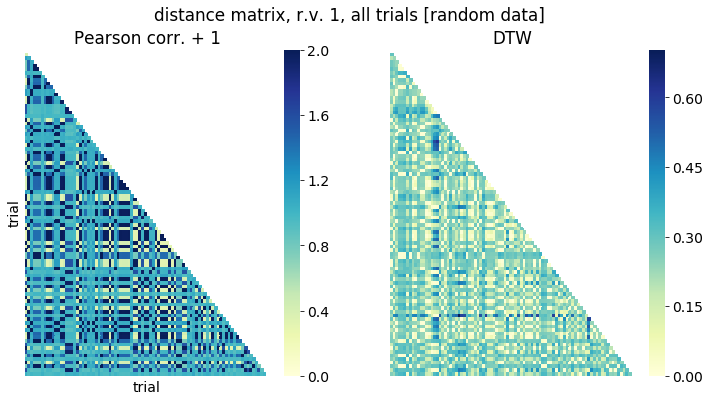

In [231]:
fig1 = plt.figure(figsize=(12, 6))
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)

mask = np.zeros_like(distances_dtw)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(distances_pearson, ax=ax1, mask=mask, cmap="YlGnBu", vmin=0, vmax=2, xticklabels=False, yticklabels=False)
ax1.set_title('Pearson corr. + 1'.format(label_map[factor]))

sns.heatmap(distances_dtw, ax=ax2, mask=mask, cmap="YlGnBu", xticklabels=False, yticklabels=False)
ax2.set_title('DTW'.format(label_map[factor]))

ax1.set_xlabel('trial')
ax1.set_ylabel('trial')

fig1.suptitle('distance matrix, r.v. 1, all trials [random data]')

In [232]:
fig1.savefig('practice_images/example_4.png', bbox_inches='tight')

In [237]:
import scipy.spatial.distance as ssd
# convert the redundant n*n square matrix form into a condensed nC2 array for use with cluster.linkage
# -- thanks to https://stackoverflow.com/a/18954990
# distArray = ssd.squareform(distMatrix) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j

# generate clusters through HAC
Z_pearson = hac.linkage(ssd.squareform(distances_pearson, checks=False), method='single', optimal_ordering=False)
Z_dtw = hac.linkage(ssd.squareform(distances_dtw, checks=False), method='single', optimal_ordering=True)

Text(0, 0.5, 'distance')

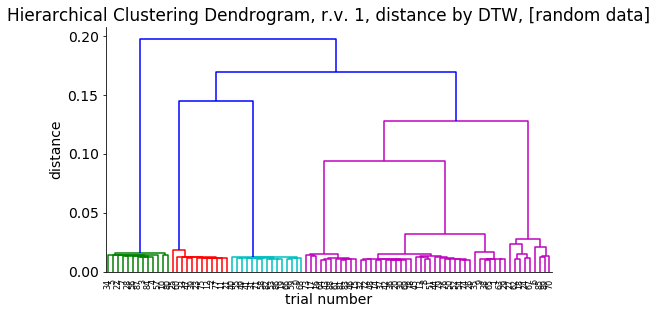

In [386]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

hac.dendrogram(
    Z_dtw,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    ax=ax1,
)

ax1.set_title('Hierarchical Clustering Dendrogram, r.v. 1, distance by DTW, [random data]')
ax1.set_xlabel('trial number')
ax1.set_ylabel('distance')

In [387]:
fig1.savefig('practice_images/example_5.png', bbox_inches='tight')

Text(0, 0.5, 'distance')

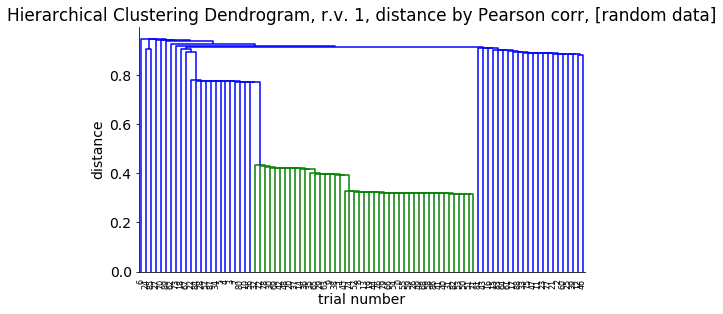

In [239]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

# Plot dendogram
hac.dendrogram(
    Z_pearson,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    ax=ax1,
)

ax1.set_title('Hierarchical Clustering Dendrogram, r.v. 1, distance by Pearson corr, [random data]')
ax1.set_xlabel('trial number')
ax1.set_ylabel('distance')

In [240]:
fig1.savefig('practice_images/example_5_2.png', bbox_inches='tight')

In [261]:
# silhouette plot

from scipy.cluster.hierarchy import fcluster
from sklearn import metrics

def get_silhouette_averages(Z, distances, k_range):
    averages = []
    for num_clusters in k_range:
        cluster_results = fcluster(Z, num_clusters, criterion='maxclust')
        silhouette_avg = metrics.silhouette_score(distances, cluster_results, metric='euclidean')
        averages.append(silhouette_avg)
    return averages


# gather data

k_range = list(range(2, 16))
averages_pearson = get_silhouette_averages(Z_pearson, distances_pearson, k_range)
averages_dtw = get_silhouette_averages(Z_dtw, distances_dtw, k_range)

Text(0, 0.5, 'silhouette coefficient')

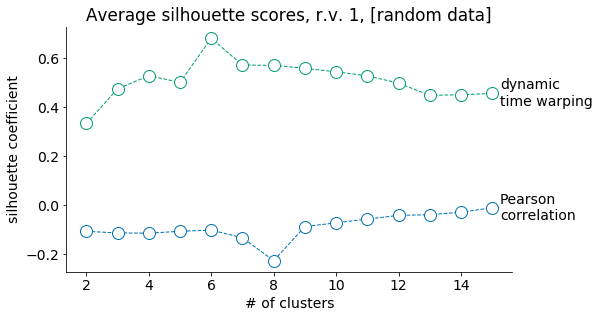

In [274]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(k_range, averages_pearson, markerfacecolor='white', linewidth=1, linestyle='--', marker='o', markersize=12)
ax1.plot(k_range, averages_dtw, markerfacecolor='white', linewidth=1, linestyle='--', marker='o', markersize=12)

ax1.annotate('Pearson\ncorrelation', (k_range[-1]+0.25, averages_pearson[-1]), ha='left', va='center', annotation_clip=False, color='black')    
ax1.annotate('dynamic\ntime warping', (k_range[-1]+0.25, averages_dtw[-1]), ha='left', va='center', annotation_clip=False, color='black')    

ax1.set_title('Average silhouette scores, r.v. 1, [random data]')
ax1.set_xlabel('# of clusters')
ax1.set_ylabel('silhouette coefficient')

In [275]:
fig1.savefig('practice_images/example_6.png', bbox_inches='tight')

In [270]:
# must specify preferred # of clusters. let's do 6 based on DTW silhouette plot

num_clusters = 6  ###

results_dtw = fcluster(Z_dtw, num_clusters, criterion='maxclust')

s = pd.Series(results_dtw)
clusters_dtw = s.unique()

for c in clusters_dtw:
    cluster_indeces = s[s==c].index
    print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
#     pd.DataFrame(cluster_data).T.iloc[:,cluster_indeces].plot()
#     plt.show()


Cluster 3 number of entries 15
Cluster 5 number of entries 30
Cluster 2 number of entries 12
Cluster 1 number of entries 13
Cluster 6 number of entries 9
Cluster 4 number of entries 11


In [335]:
# Cluster percentage plot, clustering method, single RV, single cluster

cluster_num = 4

clusters_df = design_df.copy()
# clusters_df['cluster_pearson'] = results_pearson  # not currently working on this one
clusters_df['cluster_dtw'] = results_dtw

cluster = clusters_df[clusters_df['cluster_dtw'] == cluster_num]
len_cluster = len(cluster)

# FUTURE: apply this technique to DoE plots (maybe)
percentages = []  # percentage of cluster with each factor-level
for col in design_df:
    levels = design_df[col].unique()  # assuming same sort order here as in previous unique calls; FUTURE customize order
    for level in levels:
        percentages.append(len(cluster[cluster[col] == level]) / len_cluster)


Text(0, 0.5, 'fraction of cluster')

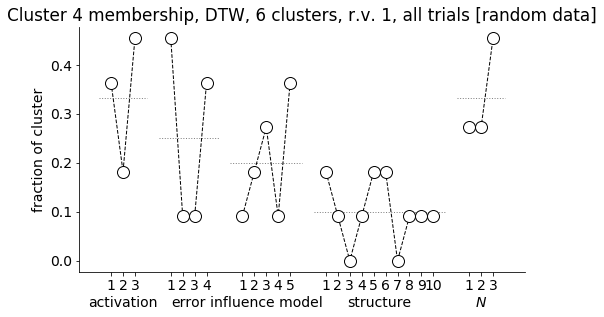

In [347]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

# assemble x tick labels
ax1.set_xticks(xticks)  # from DoE means plot
ax1.set_xticklabels(xlabels)

# grand_mean = df.mean().iloc[-1]
# ax1.axhline(y=grand_mean, color='grey', linewidth=1, linestyle=':')
# ax1.annotate('grand\nmean', (xticks[-1]+2, grand_mean), ha='left', va='center', annotation_clip=False, color='grey')

last_offset = 0
for i, factor in enumerate(factors):
    x = xticks[last_offset:last_offset+num_levels[i]]
    y = percentages[last_offset:last_offset+num_levels[i]]

    # plot the mean line first so it's z-order to the back
    ax1.hlines(1/num_levels[i], x[0]-1, x[-1]+1, 
               color='grey', linewidth=1, linestyle=':')
    
    # plot the data
    ax1.plot(x, y, color='black', 
             markerfacecolor='white', linewidth=1, linestyle='--', marker='o', markersize=12)
    
    last_offset += num_levels[i]
    

# label factor names
y = ax1.get_ybound()[0]
for label, x in factor_name_xs:
    ax1.annotate(label, (x, y), 
                 textcoords="offset points", # how to position the text
                 xytext=(0,-35), # distance from text to points (x,y)
                 ha='center', annotation_clip=False)
        
ax1.set_title('Cluster {} membership, DTW, {} clusters, r.v. 1, all trials [random data]'.format(cluster_num, num_clusters))
ax1.set_ylabel('fraction of cluster')


In [346]:
fig1.savefig('practice_images/example_7.png', bbox_inches='tight')


# RQ 3 - cross-comparison of RVs


In [376]:
# average correlation matrix of RVs
# in each trial, find corr among RVs, then average all trials and plot in a correlogram
num_RVs = data.shape[2]

all_rv_corrs = np.zeros((num_RVs, num_RVs, num_trials))

for trial_num in range(num_trials):
    trial_rv_corrs = np.zeros((num_RVs, num_RVs))
    for i in range(num_RVs):
        for j in range(num_RVs):
            if j < i:
                trial_rv_corrs[i, j] = np.corrcoef(data[trial_num, :, i], data[trial_num, :, j])[0, 1]
                
    all_rv_corrs[:, :, trial_num] = trial_rv_corrs

mean_rv_corrs = np.average(all_rv_corrs, axis=2)
stdev_rv_corrs = np.std(all_rv_corrs, axis=2)

Text(0.5, 0.98, 'correlation of r.v.s across all trials [random data]')

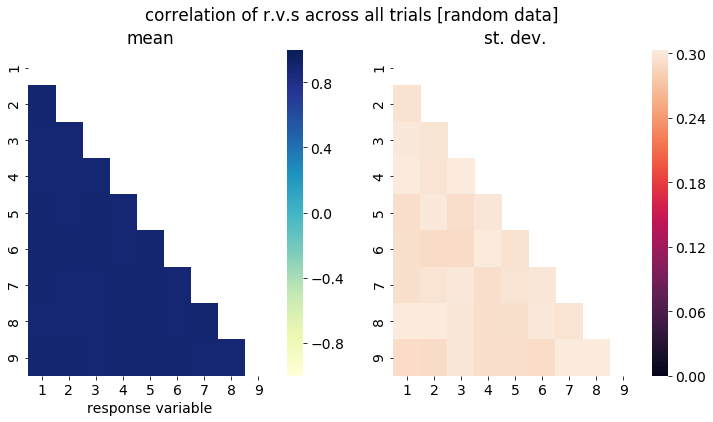

In [381]:
fig1 = plt.figure(figsize=(12, 6))
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)

mask = np.zeros_like(mean_rv_corrs)
mask[np.triu_indices_from(mask)] = True

ticklabels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

sns.heatmap(mean_rv_corrs, ax=ax1, mask=mask, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels=ticklabels, yticklabels=ticklabels)
ax1.set_title('mean')

sns.heatmap(stdev_rv_corrs, ax=ax2, mask=mask, xticklabels=ticklabels, yticklabels=ticklabels)
ax2.set_title('st. dev.')

ax1.set_xlabel('response variable')

fig1.suptitle('correlation of r.v.s across all trials [random data]')

In [382]:
fig1.savefig('practice_images/example_8.png', bbox_inches='tight')

end?